In [8]:
# Cell 1: Installs & Imports (GPU check)
# --------------------------------------
!pip install -q scikeras

import os, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TF: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Cell 2: Generate Realistic 6-Hour Sequences
# -------------------------------------------
np.random.seed(42)
window = 6

# 1) Feature list (per hour)
num_features = [
    "historical_avg_net_displacement","historical_avg_num_stops",
    "historical_avg_resting_hours","historical_avg_speed",
    "historical_avg_stop_duration_s","historical_avg_time_eating_hours",
    "historical_avg_time_null_zone_hours","historical_avg_time_sleeping_hours",
    "historical_avg_tortuosity","historical_avg_total_distance_per_hour",
    "historical_avg_turning_angle_variance","historical_avg_zone_transitions",
    "historical_hours_count","historical_total_distance",
    "historical_total_num_stops","historical_total_resting_hours",
    "historical_total_time_eating_hours","historical_total_time_null_zone_hours",
    "historical_total_time_sleeping_hours","historical_total_zone_transitions",
    "hourly_avg_nearest_neighbor_distance","hourly_avg_speed",
    "hourly_avg_stop_duration_s","hourly_net_displacement",
    "hourly_num_stops","hourly_resting_hours",
    "hourly_time_eating_hours","hourly_time_null_zone_hours",
    "hourly_time_sleeping_hours","hourly_tortuosity",
    "hourly_total_distance","hourly_turning_angle_variance",
    "hourly_zone_transitions"
]
dim_f = len(num_features)

# 2) Covariances
rho     = 0.3
Sigma_f = np.full((dim_f, dim_f), rho)
np.fill_diagonal(Sigma_f, 1.0)
tau     = 1.5
Sigma_t = np.array([[np.exp(-abs(i-j)/tau) for j in range(window)]
                    for i in range(window)])
cov_big = np.kron(Sigma_t, Sigma_f)

# 3) Class means & heteroskedastic factors
class_params = {
    "healthy": {"mean": 1.0, "het": 1.0},
    "sick":    {"mean": 0.8, "het": 0.8},
    "in_heat": {"mean": 1.2, "het": 1.2}
}
delta = 0.2
submeans = {
    lbl: [
        np.ones(dim_f * window) * (p["mean"] - delta),
        np.ones(dim_f * window) * (p["mean"] + delta)
    ]
    for lbl, p in class_params.items()
}

# 4) Sample n_seq per class
n_seq = 5000
Xs, ys = [], []
for lbl, p in class_params.items():
    cov = cov_big * (p["het"]**2)
    Xc = np.vstack([
        np.random.multivariate_normal(
            submeans[lbl][np.random.randint(2)], cov
        )
        for _ in range(n_seq)
    ])
    y = np.array([lbl] * n_seq)
    Xs.append(Xc)
    ys.append(y)

X = np.vstack(Xs)            # (3*n_seq, window*dim_f)
y = np.concatenate(ys)

# 5) Inject label-noise (2%) & outliers (1%)
n_noise = int(0.02 * len(y))
idx_noise = np.random.choice(len(y), n_noise, replace=False)
for i in idx_noise:
    y[i] = np.random.choice([c for c in class_params if c != y[i]])

n_out = int(0.01 * len(y))
idx_out = np.random.choice(len(y), n_out, replace=False)
for i in idx_out:
    X[i] *= np.random.uniform(2.0, 3.0)

print("X:", X.shape, "labels:", np.unique(y, return_counts=True))


X: (15000, 198) labels: (array(['healthy', 'in_heat', 'sick'], dtype='<U7'), array([5003, 4996, 5001]))


In [10]:
# Cell 3: Encode, Scale & Split → plus reshape for Conv1D
# -------------------------------------------------------
le    = LabelEncoder().fit(y)
y_int = le.transform(y).astype(int)

scaler = StandardScaler().fit(X)
X_scl  = scaler.transform(X)

# 20% hold-out, then 10% of remaining → val
X_tmp, X_hold, y_tmp, y_hold = train_test_split(
    X_scl, y_int, test_size=0.20, stratify=y_int, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.10, stratify=y_tmp, random_state=42
)

# reshape flat → (batch, window, dim_f)
X_train_seq = X_train.reshape(-1, window, dim_f)
X_val_seq   = X_val.reshape(-1,   window, dim_f)
X_hold_seq  = X_hold.reshape(-1,  window, dim_f)

# one-hot for label-smoothing loss
y_train_ohe = tf.keras.utils.to_categorical(y_train, num_classes=len(le.classes_))
y_val_ohe   = tf.keras.utils.to_categorical(y_val,   num_classes=len(le.classes_))

print("Train:", X_train_seq.shape, y_train_ohe.shape)
print("Val:  ", X_val_seq.shape,   y_val_ohe.shape)
print("Hold: ", X_hold_seq.shape,  y_hold.shape)


Train: (10800, 6, 33) (10800, 3)
Val:   (1200, 6, 33) (1200, 3)
Hold:  (3000, 6, 33) (3000,)


In [11]:
# Cell 4 (fixed): Build & compile Conv1D model
# --------------------------------------------
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# number of output classes
num_classes = len(le.classes_)

inp = layers.Input(shape=(window, dim_f))
x   = layers.GaussianNoise(0.05)(inp)       # cut noise in half

x   = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x   = layers.BatchNormalization()(x)
x   = layers.Conv1D(64, 3, activation="relu", padding="same")(x)
x   = layers.BatchNormalization()(x)

x   = layers.GlobalAveragePooling1D()(x)
x   = layers.Dense(128, activation="relu",
                   kernel_regularizer=regularizers.l2(1e-5))(x)  # looser L2
x   = layers.Dropout(0.2)(x)                                 # less dropout

# now num_classes is defined
out = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inp, out)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 33)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 6, 33)          │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 6, 64)          │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 6, 64)          │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,971 (109.26 KB)

 Trainable params: 27,715 (108.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
# Cell 5 (updated): Standard training without crazy schedule
# ----------------------------------------------------------
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
]

history = model.fit(
    X_train_seq, y_train_ohe,
    validation_data=(X_val_seq, y_val_ohe),
    epochs=80,                   # a bit shorter
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.5914 - loss: 0.8984 - val_accuracy: 0.3500 - val_loss: 1.1117 - learning_rate: 0.0010
Epoch 2/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8211 - loss: 0.5896 - val_accuracy: 0.7658 - val_loss: 0.6685 - learning_rate: 0.0010
Epoch 3/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8584 - loss: 0.5027 - val_accuracy: 0.8233 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 4/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8732 - loss: 0.4606 - val_accuracy: 0.8483 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 5/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8923 - loss: 0.4291 - val_accuracy: 0.8408 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 6/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9038 - loss: 0.3968 - val_accuracy: 0.8467 - val_loss: 0.5397 - learning_rate: 0.0010
Epoch 7/80
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9138 - loss: 0.3824 - val_accuracy

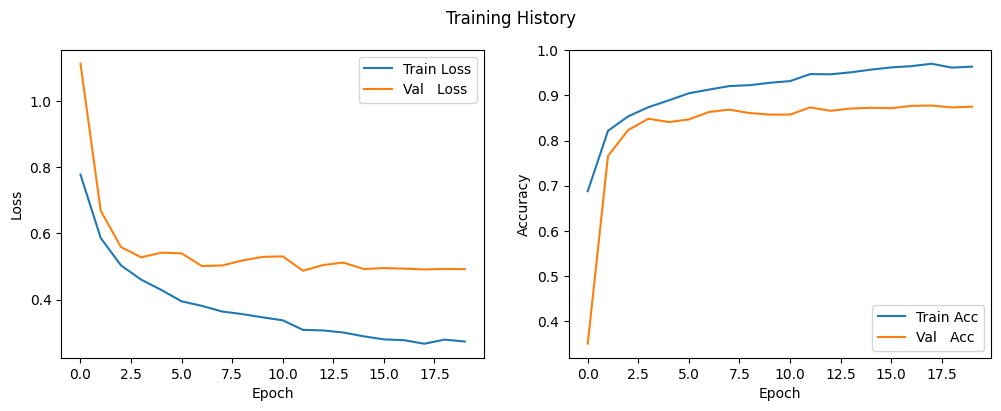

In [13]:
# Cell 6: Plot Loss & Accuracy Curves
# -----------------------------------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"],  label="Train Loss")
plt.plot(history.history["val_loss"], label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"],  label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val   Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.suptitle("Training History")
plt.show()


In [14]:
# Cell 7: Evaluate on Hold-Out
# ----------------------------
loss, acc = model.evaluate(X_hold_seq, tf.keras.utils.to_categorical(y_hold, num_classes), verbose=0)
print(f"Hold-out ⇒  Loss={loss:.3f},  Acc={acc:.3f}\n")

y_pred = model.predict(X_hold_seq).argmax(axis=1)
print(classification_report(
    y_hold, y_pred, target_names=le.classes_
))


Hold-out ⇒  Loss=0.449,  Acc=0.881

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

     healthy       0.83      0.84      0.83      1001
     in_heat       0.89      0.87      0.88       999
        sick       0.92      0.93      0.92      1000

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [15]:
import firebase_admin
from firebase_admin import credentials, firestore, initialize_app

# —– initialize once (you already have this above) —–
FIREBASE_KEY_PATH = "/content/firebase-key.json"
cred = credentials.Certificate(FIREBASE_KEY_PATH)
initialize_app(cred)
db = firestore.client()


In [16]:
# Cell 8: Build hold-out DataFrame for live inference
# ---------------------------------------------------
hold_df = pd.DataFrame({
    "cow_id":     np.random.choice([str(i) for i in range(1,51)], size=len(X_hold_seq)),
    "sequence":   list(X_hold_seq),
    "true_label": [le.classes_[i] for i in y_hold]
})


In [31]:
# — Cell 8.5: Build a GradientExplainer (after training, before your live loop) —

import shap

# pick ~100 background sequences for the explainer
background = X_train_seq[np.random.choice(len(X_train_seq), 100, replace=False)]

# use the GradientExplainer on your Keras model
explainer = shap.GradientExplainer(model, background)


In [34]:
# Cell 9: Continuous Batch Inference + Batch Report + Firebase Alerts
# -------------------------------------------------------------------
import time
def explain_batch_saliency(Xb, preds_i):
    """Compute per-feature saliency = mean over time of |grad·input|."""
    Xb_tf = tf.convert_to_tensor(Xb, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(Xb_tf)
        logits = model(Xb_tf)  # (batch, num_classes)
        idx    = tf.stack([tf.range(tf.shape(logits)[0]), preds_i], axis=1)
        sel    = tf.gather_nd(logits, idx)  # (batch,)
    grads = tape.gradient(sel, Xb_tf)      # (batch, window, dim_f)
    sal   = tf.reduce_mean(tf.abs(grads * Xb_tf), axis=1)  # (batch, dim_f)
    return sal.numpy()

def run_batch(batch_df):
    # 1) Prepare inputs & get preds
    Xb          = np.stack(batch_df["sequence"].values)            # (batch, window, dim_f)
    probs       = model.predict(Xb, verbose=0)                     # (batch, num_classes)
    preds_i     = probs.argmax(axis=1)                             # (batch,)
    preds       = [le.classes_[i] for i in preds_i]
    confidences = probs[np.arange(len(preds_i)), preds_i]

    # 2) Print batch header & per‐cow prediction
    print(f"\n=== Batch @ {pd.Timestamp.now()} ===")
    for i, row in batch_df.iterrows():
        true = row["true_label"]
        cow  = row["cow_id"]
        p    = confidences[i]
        print(f"Cow {cow:>2} | True: {true:<8} → Pred: {preds[i]:<8} (p={p:.2f})")

    # 3) Batch classification report
    print("\nBatch report:")
    print(classification_report(batch_df["true_label"], preds, target_names=le.classes_))

    # 4) Compute saliency once per batch
    saliency = explain_batch_saliency(Xb, preds_i)  # (batch, dim_f)

    # 5) For each *non-healthy* cow, print & upload an alert
    for i, row in batch_df.iterrows():
        label = preds[i]
        if label == "healthy":
            continue

        cow_id = row["cow_id"]
        conf   = float(confidences[i])
        imp    = saliency[i]
        thresh = imp.mean()

        # all features whose saliency > sample’s mean saliency
        feature_impacts = [
            {"feature": num_features[k], "impact": float(imp[k])}
            for k in range(len(num_features))
            if imp[k] > thresh
        ]

        # print warning
        print(f"\n⚠️ ALERT: Cow {cow_id} → {label} (p={conf:.2f})")
        for item in feature_impacts:
            print(f"   • {item['feature']}: {item['impact']:.3f}")

        # upload to Firestore
        alert_doc = {
            "cow_id":          cow_id,
            "predicted_label": label,
            "confidence":      conf,
            "feature_impacts": feature_impacts,
            "timestamp":       firestore.SERVER_TIMESTAMP
        }
        db.collection("alerts").add(alert_doc)

    print("\n…waiting 60s until next batch…\n")

# infinite loop: sample 50, run, wait 60s
while True:
    batch = hold_df.sample(n=50).reset_index(drop=True)
    run_batch(batch)
    time.sleep(60)


Strømmer utdata som er avkortet til de siste 5000 linjene.
   • hourly_total_distance: 0.002
   • hourly_zone_transitions: 0.002

⚠️ ALERT: Cow 30 → in_heat (p=0.85)
   • historical_avg_net_displacement: 0.034
   • historical_avg_resting_hours: 0.033
   • historical_avg_speed: 0.035
   • historical_avg_stop_duration_s: 0.046
   • historical_avg_time_eating_hours: 0.037
   • historical_avg_tortuosity: 0.053
   • historical_total_time_null_zone_hours: 0.028
   • historical_total_zone_transitions: 0.032
   • hourly_avg_speed: 0.038
   • hourly_avg_stop_duration_s: 0.031
   • hourly_time_null_zone_hours: 0.044
   • hourly_tortuosity: 0.026
   • hourly_total_distance: 0.046
   • hourly_zone_transitions: 0.030

⚠️ ALERT: Cow 13 → sick (p=0.96)
   • historical_avg_resting_hours: 0.005
   • historical_avg_stop_duration_s: 0.004
   • historical_avg_time_eating_hours: 0.004
   • historical_avg_tortuosity: 0.003
   • historical_avg_total_distance_per_hour: 0.005
   • historical_total_time_null_zo

KeyboardInterrupt: 